In [2]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [10]:
titles = open('title_list.txt').read().split('\n')
titles = titles[:100]
links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

In [17]:
clean_synopses_wiki = [BeautifulSoup(text, 'html.parser').getText() for text in synopses_wiki]

synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]
clean_synopses_imdb = [BeautifulSoup(text, 'html.parser').getText() for text in synopses_imdb]

In [22]:
synopses = []
for i in range(len(titles)):
    synopses.append(clean_synopses_wiki[i] + clean_synopses_imdb[i])

In [23]:
ranks = []
for i in range(len(titles)):
    ranks.append(i)

#### Stopwords, Stemming & Tokenizing

In [24]:
from nltk.stem.snowball import SnowballStemmer
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

`sent_tokenize`: text can be split into sentences

`word_tokenize`: sentence/data can be split into words

In [36]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems  

def tokenize_only(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    return filtered_tokens

In [45]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for s in synopses:
    totalvocab_stemmed.extend(tokenize_and_stem(s))
    totalvocab_tokenized.extend(tokenize_only(s))

In [46]:
len(totalvocab_tokenized), len(totalvocab_stemmed)

(312302, 312302)

In [47]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame.head()

,words
plot,Plot
edit,edit
edit,edit
edit,edit
on,On


#### TF-IDF & Document Similarity
`TF-IDF Matrix`
* Count word occurrences by document
* Apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document
<img src="tf_idf.png" width="300" align='center'> 

**Parameters in `TfidfVectorizer` Function**
* max_df:the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining
* min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here 0.2 is passed - the term must be in at least 20% of the document.
* ngram_range: this just means we are looking at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.25, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
print(tfidf_matrix.shape)

/Users/jinlinsi/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 8 s, sys: 83.9 ms, total: 8.08 s
Wall time: 8.25 s
(100, 400)


In [89]:
terms = tfidf_vectorizer.get_feature_names()
len(terms)

400

`cosine_distance = 1 - cosine_similarity`\
If 2 vectors are the same, then **similarity** is 1, and thus **distance** is 1 - 1 = 0

In [90]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist.shape

(100, 100)

#### K-Means Clustering

In [91]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 97.5 ms, sys: 4.32 ms, total: 102 ms
Wall time: 125 ms


In [92]:
films_df = pd.DataFrame( { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }, 
                     index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
films_df.head()

,rank,title,cluster,genre
1,0,The Godfather,1,"[u' Crime', u' Drama']"
1,1,The Shawshank Redemption,1,"[u' Crime', u' Drama']"
3,2,Schindler's List,3,"[u' Biography', u' Drama', u' History']"
4,3,Raging Bull,4,"[u' Biography', u' Drama', u' Sport']"
3,4,Casablanca,3,"[u' Drama', u' Romance', u' War']"


In [94]:
from __future__ import print_function

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()
    print("Cluster %d titles:" % i, end='')
    for title in films_df.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:
Cluster 0 words: relationship, love, marriage, death, John, murders,
Cluster 0 titles: Titanic, Vertigo, Forrest Gump, 12 Angry Men, Amadeus, City Lights, A Place in the Sun, Annie Hall, Out of Africa, Good Will Hunting, The Green Mile, The Graduate, Wuthering Heights,

Cluster 1 words: family, home, War, sister, marries, mother,
Cluster 1 titles: The Godfather, The Shawshank Redemption, Gone with the Wind, The Wizard of Oz, The Sound of Music, E.T. the Extra-Terrestrial, A Streetcar Named Desire, The Philadelphia Story, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Pianist, Goodfellas, The Exorcist, The King's Speech, Terms of Endearment, Giant, The Grapes of Wrath, Yankee Doodle Dandy,

Cluster 2 words: car, Police, killed, Mr., father, says,
Cluster 2 titles: Psycho, Sunset Blvd., On the Waterfront, West Side Story, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, It's a Wonderful Life, Some Like It Hot, Gandhi, Unforgiven,

#### Multidimensional Scaling
`MDS`: A technique used for analyzing similarity or dissimilarity of data through distances in a geometric spaces. See [MDS](https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling)

In [95]:
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()
# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

#### Visualize Document Clusters

In [96]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'relationship, love, death',
                 1: 'family, home, war',
                 2: 'police, killed, murders',
                 3: 'killed, soldiers, captain',
                 4: 'film, New York, apartment'}
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

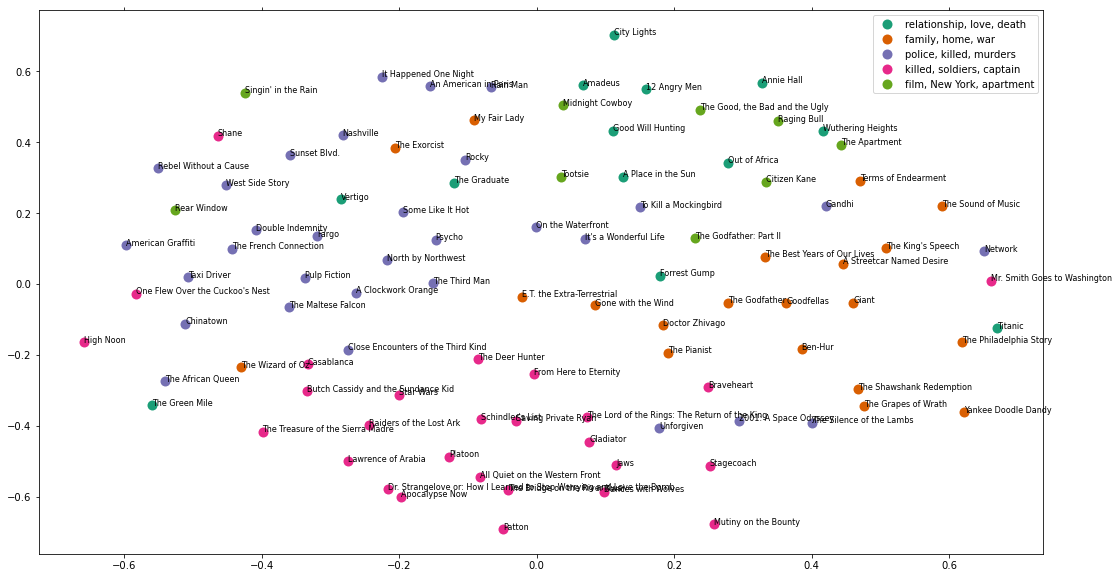

In [102]:
# set up plot
fig, ax = plt.subplots(figsize=(18, 10)) # set size
ax.margins(0.05) 
groups = df.groupby('label')
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=cluster_names[name], 
            color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)      
plt.show()

#### Hierarchical Document Clustering

`linkage`: A method takes the dataset and the method to minimize distances as parameters \
`ward`: A method that tries to minimize the variance within each cluster (a method with in `linkage`)

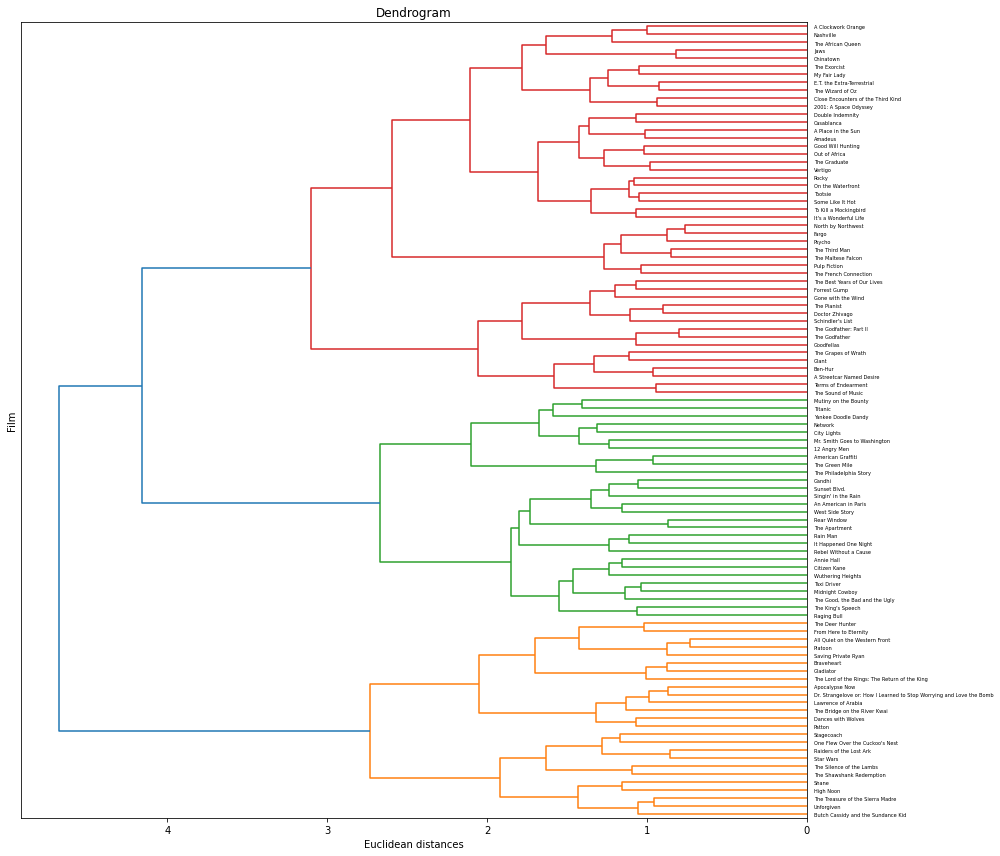

In [120]:
from scipy.cluster.hierarchy import ward, dendrogram, linkage
fig, ax = plt.subplots(figsize=(14, 12))
ddg = dendrogram(linkage(dist, method = 'ward'), labels = titles, orientation="left")
plt.title('Dendrogram')
plt.xlabel('Euclidean distances')
plt.ylabel('Film')
plt.tight_layout()
plt.show()
# plt.savefig('ward_clusters.png', dpi=200)

In [123]:
from sklearn.cluster import AgglomerativeClustering 
ac = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_ac = ac.fit_predict(dist)

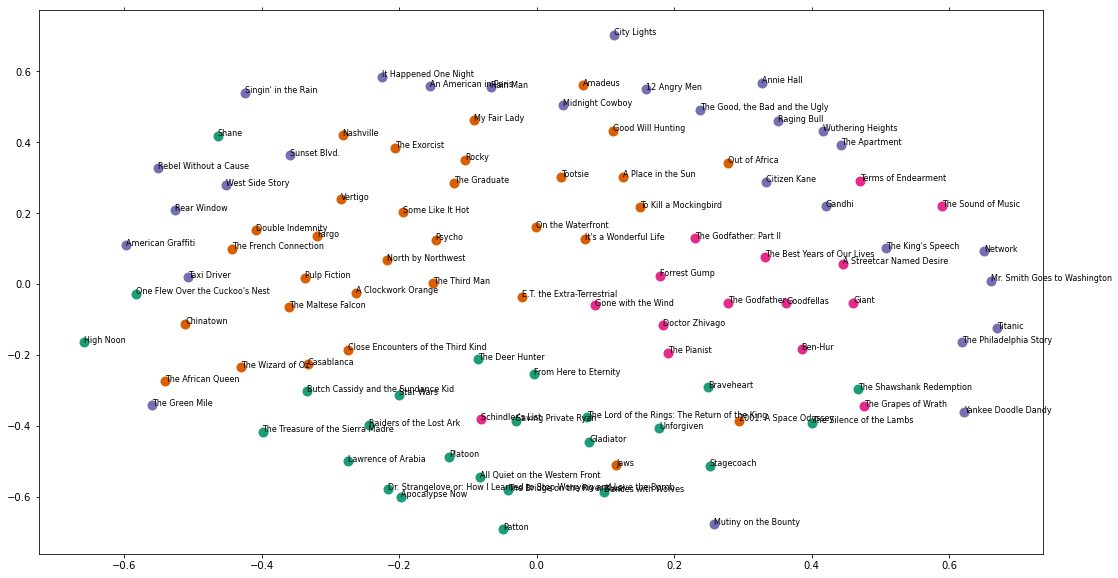

In [126]:
ac_df = pd.DataFrame(dict(x=xs, y=ys, label=ac.labels_, title=titles)) 

fig, ax = plt.subplots(figsize=(18, 10)) # set size
ax.margins(0.05) 
ac_groups = ac_df.groupby('label')
for name, group in ac_groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, 
            color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(ac_df.loc[i]['x'], ac_df.loc[i]['y'], ac_df.loc[i]['title'], size=8)      
plt.show()

In [158]:
X = pd.DataFrame(tfidf_matrix.toarray(), columns = list(tfidf_vectorizer.vocabulary_.keys()))
X['cluster'] = ac.labels_
X.head()

,day,daughter,hear,new,york,famili,son,introduc,help,movi,...,troubl,depart,determin,investig,repeat,appar,draw,someon,reluct,cluster
0,0.000000,0.091189,0.015005,0.037597,0.000000,0.000000,0.013943,0.014142,0.040606,0.000000,...,0.000000,0.011368,0.000000,0.000000,0.013200,0.0,0.083843,0.060955,0.041975,3
1,0.025974,0.000000,0.000000,0.012166,0.014793,0.000000,0.027070,0.013729,0.019709,0.000000,...,0.013165,0.011036,0.015029,0.106269,0.038443,0.0,0.063305,0.000000,0.010187,0
2,0.021724,0.000000,0.048730,0.000000,0.000000,0.049491,0.000000,0.000000,0.032969,0.000000,...,0.044043,0.036921,0.226256,0.029627,0.150047,0.0,0.000000,0.000000,0.000000,3
3,0.000000,0.000000,0.023047,0.000000,0.000000,0.000000,0.021416,0.000000,0.000000,0.023779,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.071545,0.163845,0.000000,2
4,0.000000,0.000000,0.058323,0.000000,0.000000,0.029617,0.000000,0.000000,0.039459,0.000000,...,0.000000,0.000000,0.000000,0.053189,0.051310,0.0,0.018106,0.000000,0.000000,1


In [166]:
X.groupby('cluster').sum()
# X.groupby('cluster').sum().loc[2,:].sort_values(ascending = False)[:5]

,day,daughter,hear,new,york,famili,son,introduc,help,movi,...,wound,troubl,depart,determin,investig,repeat,appar,draw,someon,reluct
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.288255,0.478159,0.350328,0.427266,0.287970,0.232675,0.209802,0.429542,0.562862,0.688118,...,0.482575,0.335537,0.296726,0.287614,0.486355,0.611067,1.793830,0.419285,0.113591,0.521675
1,0.555729,0.559062,0.167171,0.639712,0.318479,0.738551,0.739474,0.285255,1.078806,0.573252,...,0.903527,0.711817,1.704240,0.656677,1.801269,0.857289,0.333485,0.958910,0.517366,0.908621
2,0.351915,0.506210,0.212474,0.662693,0.366674,0.278521,0.240834,0.419375,0.876882,0.492868,...,0.751029,0.421643,1.222906,0.397824,1.130496,0.720538,0.183162,1.186294,2.043549,0.711451
3,0.191377,0.555250,0.318561,0.191744,0.159801,0.165210,0.134903,0.277909,0.446561,0.257303,...,0.057769,0.507849,0.392735,0.564484,0.589449,0.764581,0.346431,0.711803,0.598726,0.747677


#### Latent Dirichlet Allocation

In [178]:
from nltk.tag import pos_tag
def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [180]:
import string
def strip_proppers(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [181]:
from gensim import corpora, models, similarities 
preprocess = [strip_proppers(doc) for doc in synopses]
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 5.06 s, sys: 95.9 ms, total: 5.15 s
Wall time: 5.82 s
CPU times: user 415 ms, sys: 3.46 ms, total: 418 ms
Wall time: 421 ms


In [182]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [184]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpus[:2]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 2),
  (5, 1),
  (6, 6),
  (7, 7),
  (8, 1),
  (9, 1),
  (10, 4),
  (11, 1),
  (12, 3),
  (13, 2),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 3),
  (26, 7),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 4),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 2),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 4),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 5),
  (47, 3),
  (48, 1),
  (49, 9),
  (50, 15),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 4),
  (55, 2),
  (56, 4),
  (57, 8),
  (58, 1),
  (59, 1),
  (60, 3),
  (61, 1),
  (62, 2),
  (63, 6),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 1),
  (69, 2),
  (70, 2),
  (71, 2),
  (72, 1),
  (73, 6),
  (74, 4),
  (75, 6),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 2),
  (80, 3),
  (81, 1),
  (82, 3),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 2),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 8

In [185]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, 
                            chunksize=10000, passes=100)

CPU times: user 35.9 s, sys: 316 ms, total: 36.2 s
Wall time: 37.4 s


In [209]:
topics = lda.print_topics(5, num_words=20)
topics_matrix = lda.show_topics(formatted=False, num_words=20)
# topics_matrix = np.array(topics_matrix)

for i in range(len(topics_matrix)):
    print(np.array(topics_matrix[i][1])[:,0])

['go' 'love' 'come' 'friend' 'show' 'sing' "n't" 'call' 'ask' 'day' 'doe'
 'meet' 'car' 'first' 'play' 'explain' 'say' 'perform' 'film' 'arriv']
['kill' 'car' 'two' 'say' "n't" 'go' 'arriv' 'ask' 'night' 'goe' 'polic'
 'offic' 'shoot' 'meet' 'drive' 'call' 'shark' 'away' 'look' 'murder']
['home' 'prison' 'two' 'kill' 'help' 'escap' 'use' 'friend' 'offic'
 'first' 'ask' 'hous' 'ship' 'day' 'arriv' 'away' 'discov' 'order' 'name'
 'guard']
['famili' 'father' 'kill' 'home' 'say' 'meet' 'life' 'brother' 'attempt'
 'friend' 'know' 'order' 'war' 'ask' 'live' 'arriv' 'money' 'marri' "n't"
 'also']
['fight' 'kill' 'men' 'ask' 'father' 'home' 'soldier' 'day' 'order'
 'becom' 'want' 'run' 'meet' 'friend' 'love' 'go' 'two' 'call' 'wife'
 'night']
